In [14]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K

# Custom Networks
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet
from networks.Inception_Resnet_V1_RPM import Inception_Resnet_V1_RPM
# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

In [15]:
def load_data(file_name):
    attack_image = np.loadtxt(file_name+"_attack_image.csv", delimiter=",")
    attack_free_image = np.loadtxt(file_name+"_attack_free_image.csv", delimiter=",")
    attack_image_seq = np.loadtxt(file_name+"_attack_image_seq.csv", delimiter=',')
    attakc_free_image_seq = np.loadtxt(file_name+"_attack_free_image_seq.csv", 
                                       delimiter=',')
    attack_image = attack_image.reshape(
        attack_image.shape[0], 29, 29, 1
    )
    attack_free_image = attack_free_image.reshape(
        attack_free_image.shape[0], 29, 29, 1
    )
    attack_y = np.array([[1]] * attack_image.shape[0])
    attack_free_y = np.array([[0]] * attack_free_image.shape[0])
    
    return (attack_image, attack_y, attack_image_seq) 
#     x_data = np.concatenate((attack_image, attack_free_image))
#     x_data_seq = np.concatenate((attakc_image_seq, attakc_free_image_seq))
#     y_data = np.concatenate((attack_y, attack_free_y))

#     train_x = x_data[:int(x_data.shape[0] * 0.7)]
#     test_x = x_data[int(x_data.shape[0] * 0.7):]
#     train_x_seq = x_data_seq[:int(x_data.shape[0] * 0.7)]
#     test_x_seq = x_data_seq[int(x_data.shape[0] * 0.7):]
#     train_y = y_data[:int(x_data.shape[0] * 0.7)]
#     test_y = y_data[int(x_data.shape[0] * 0.7):]

#     return (train_x, train_y), (test_x, test_y), (train_x_seq, test_x_seq)

In [4]:
# (x_train, y_train), (x_test, y_test), (x_train_seq, x_test_seq) = load_data("./CAN_DATA/DoS")
(attack_image, attack_y, attack_image_seq) = load_data("./CAN_DATA/RPM")

In [16]:
class_names = ['normal', 'attack']
print(len(attack_image))

71372


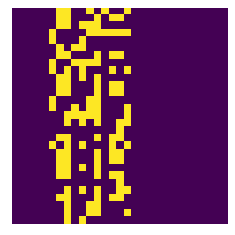

[1]
[0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0.]


In [17]:
image_id = 600
helper.plot_image(attack_image[image_id])
print(attack_y[image_id])
print(attack_image_seq[image_id])


In [18]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 3)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs
    

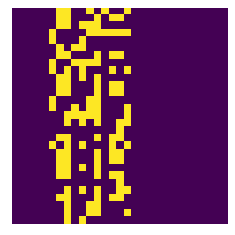

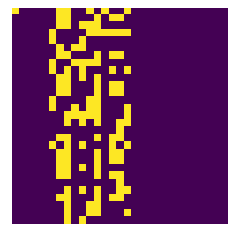

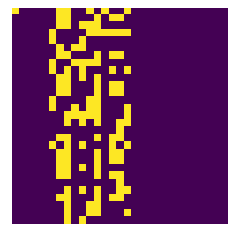

In [19]:
imgae_id = 100
pixel = np.array([[0.82811573, 0.12493119, 1.5], [0, 0, 1]])
image_perturbed = perturb_image(pixel, attack_image[image_id])[0]
image_perturbed_1 = perturb_image(pixel, attack_image[image_id])[1]
helper.plot_image(attack_image[image_id])
helper.plot_image(image_perturbed)
helper.plot_image(image_perturbed_1)

In [27]:
Inception_Resnet_V1_RPM = Inception_Resnet_V1_RPM()
models = [Inception_Resnet_V1_RPM]

Successfully loaded Inception_Resnet_V1_RPM


In [28]:
network_stats, correct_imgs = helper.evaluate_models(models,attack_image, attack_y)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating Inception_Resnet_V1_RPM


,name,accuracy,param_count
0,Inception_Resnet_V1_RPM,0.996399,1691490


In [29]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

In [30]:
def predict_1(img, model):
    img_reshape = img.reshape([1, 29, 29, 1])
    prior_confidence = model.predict_one(img_reshape)
    return prior_confidence

Confidence in true class attack is 0.99999535
Prior confidence was 0.999979


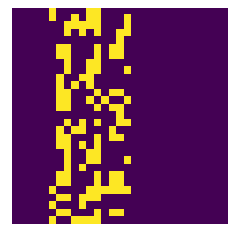

In [62]:
image_id = 384
pixel = np.array([16, 13, 1])
model = Inception_Resnet_V1

true_class = attack_y[image_id, 0]
prior_confidence = predict_1(attack_image[image_id], model)[true_class]
confidence = predict_classes(pixel, attack_image[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, attack_image[image_id])[0])

In [32]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

Confidence: 0.9999331
Prior confidence [5.2873179e-06 9.9999475e-01]
Attack success: False


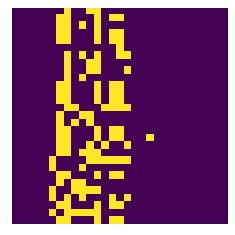

In [33]:
image_id = 541
pixel = np.array([17, 18, 1])
model = Inception_Resnet_V1
true_class = attack_y[image_id, 0]
prior_confidence = predict_1(attack_image[image_id], model)
success = attack_success(pixel, attack_image[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, attack_image[image_id])[0])

In [60]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else attack_y[img_id, 0]
    test_seq = attack_image_seq[img_id]
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    attack_point = 1
    bounds = []
    for i in range(0, len(test_seq)):
        if test_seq[i] == 1 and attack_point == 1:
            bound = [(i, i+1), (0, 29), (0, 2)] * pixel_count
            
            bounds = bounds + bound
            attack_point = 0
            
        elif test_seq[i] == 1 and attack_point == 0:
            attack_point = 1
            
        else:
            continue
    
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, attack_image[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, attack_image[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)
    #print(attack_result.x)
    # Calculate some useful statistics to return from this function
    attack_image_ = perturb_image(attack_result.x, attack_image[img_id])[0]
    true_class = attack_y[image_id, 0]
    prior_probs = predict_1(attack_image[img_id], model)
    predicted_probs = predict_1(attack_image_, model)

    
    predicted_class = np.argmax(predicted_probs)
    #print(predicted_class)
    actual_class = attack_y[img_id, 0]
    #print(actual_class)
    success = predicted_class != actual_class
    #cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image_, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, prior_probs, predicted_probs, attack_result.x]

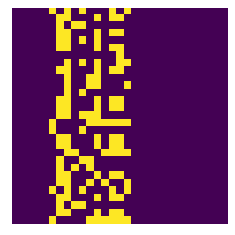

Confidence: 0.012874148


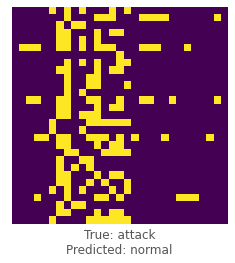

In [66]:
image_id = 500
pixels = 15 # Number of pixels to attack
model = Inception_Resnet_V1
helper.plot_image(attack_image[image_id])
_ = attack(image_id, model, pixel_count=pixels, verbose=True)

In [58]:
def attack_all(model, pixels = 29, targeted = False,
              maxiter = 75, popsize = 400, verbose = False):
    
    
    success_results = []
    fail_results = []
    total_length = len(attack_image)
    for img_id, img in enumerate(attack_image):
        result = attack(img_id, model, target = None, pixel_count = pixels,
                       maxiter = maxiter, popsize = popsize, verbose = verbose)
        if result[5] == True:
            success_results.append(result)
        else:
            fail_results.append(result)
        
        if img_id % 100 == 0:
            print("진행률 : ",img_id,"/",total_length)
            print("현재 탐지 율 : ", (len(fail_results)) / (len(success_results) + len(fail_results)))
    
        
    return success_results, fail_results
        

In [59]:
success_results, fail_results = attack_all(model)
detection_rate = (len(fail_results) / (len(success_results) + len(fail_results)))

print("detection_rate : ", detection_rate)

진행률 :  0 / 71372
현재 탐지 율 :  0.0
진행률 :  100 / 71372
현재 탐지 율 :  0.0
진행률 :  200 / 71372
현재 탐지 율 :  0.0
진행률 :  300 / 71372
현재 탐지 율 :  0.0
진행률 :  400 / 71372
현재 탐지 율 :  0.0
진행률 :  500 / 71372
현재 탐지 율 :  0.0
진행률 :  600 / 71372
현재 탐지 율 :  0.0
진행률 :  700 / 71372
현재 탐지 율 :  0.0
진행률 :  800 / 71372
현재 탐지 율 :  0.0
진행률 :  900 / 71372
현재 탐지 율 :  0.0
진행률 :  1000 / 71372
현재 탐지 율 :  0.0
진행률 :  1100 / 71372
현재 탐지 율 :  0.0
진행률 :  1200 / 71372
현재 탐지 율 :  0.0
진행률 :  1300 / 71372
현재 탐지 율 :  0.0
진행률 :  1400 / 71372
현재 탐지 율 :  0.0
진행률 :  1500 / 71372
현재 탐지 율 :  0.0
진행률 :  1600 / 71372
현재 탐지 율 :  0.0
진행률 :  1700 / 71372
현재 탐지 율 :  0.0
진행률 :  1800 / 71372
현재 탐지 율 :  0.0
진행률 :  1900 / 71372
현재 탐지 율 :  0.0
진행률 :  2000 / 71372
현재 탐지 율 :  0.0
진행률 :  2100 / 71372
현재 탐지 율 :  0.0
진행률 :  2200 / 71372
현재 탐지 율 :  0.0
진행률 :  2300 / 71372
현재 탐지 율 :  0.0
진행률 :  2400 / 71372
현재 탐지 율 :  0.0
진행률 :  2500 / 71372
현재 탐지 율 :  0.0
진행률 :  2600 / 71372
현재 탐지 율 :  0.0
진행률 :  2700 / 71372
현재 탐지 율 :  0.0
진행률 :  2800 / 71372
현재 탐지 율 :  0

진행률 :  17100 / 71372
현재 탐지 율 :  0.0001754283375241214
진행률 :  17200 / 71372
현재 탐지 율 :  0.00017440846462414976
진행률 :  17300 / 71372
현재 탐지 율 :  0.00017340038148083925
진행률 :  17400 / 71372
현재 탐지 율 :  0.00017240388483420494
진행률 :  17500 / 71372
현재 탐지 율 :  0.00017141877606993887
진행률 :  17600 / 71372
현재 탐지 율 :  0.0001704448610874382
진행률 :  17700 / 71372
현재 탐지 율 :  0.00016948195017230664
진행률 :  17800 / 71372
현재 탐지 율 :  0.00016852985787315318
진행률 :  17900 / 71372
현재 탐지 율 :  0.00016758840288252054
진행률 :  18000 / 71372
현재 탐지 율 :  0.00022220987722904284
진행률 :  18100 / 71372
현재 탐지 율 :  0.0002209822661731396
진행률 :  18200 / 71372
현재 탐지 율 :  0.00021976814460743916
진행률 :  18300 / 71372
현재 탐지 율 :  0.00021856729140484125
진행률 :  18400 / 71372
현재 탐지 율 :  0.00021737949024509538
진행률 :  18500 / 71372
현재 탐지 율 :  0.0002162045294848927
진행률 :  18600 / 71372
현재 탐지 율 :  0.0002150422020321488
진행률 :  18700 / 71372
현재 탐지 율 :  0.00021389230522431956
진행률 :  18800 / 71372
현재 탐지 율 :  0.0002127546407106005
진행률 :  18900 / 7

진행률 :  32100 / 71372
현재 탐지 율 :  0.000186910065107006
진행률 :  32200 / 71372
현재 탐지 율 :  0.00018632961709263686
진행률 :  32300 / 71372
현재 탐지 율 :  0.0001857527630723507
진행률 :  32400 / 71372
현재 탐지 율 :  0.00018517946976945155
진행률 :  32500 / 71372
현재 탐지 율 :  0.00018460970431679024
진행률 :  32600 / 71372
현재 탐지 율 :  0.00018404343425048312
진행률 :  32700 / 71372
현재 탐지 율 :  0.00018348062750374607
진행률 :  32800 / 71372
현재 탐지 율 :  0.00018292125240084144
진행률 :  32900 / 71372
현재 탐지 율 :  0.00018236527765113522
진행률 :  33000 / 71372
현재 탐지 율 :  0.00018181267234326234
진행률 :  33100 / 71372
현재 탐지 율 :  0.0001812634059393976
진행률 :  33200 / 71372
현재 탐지 율 :  0.00018071744826963042
진행률 :  33300 / 71372
현재 탐지 율 :  0.00018017476952644066
진행률 :  33400 / 71372
현재 탐지 율 :  0.00017963534025927368
진행률 :  33500 / 71372
현재 탐지 율 :  0.00017909913136921287
진행률 :  33600 / 71372
현재 탐지 율 :  0.00017856611410374692
진행률 :  33700 / 71372
현재 탐지 율 :  0.00017803626005163053
진행률 :  33800 / 71372
현재 탐지 율 :  0.00017750954113783616
진행률 :  33900 /

KeyboardInterrupt: 